# This code is taken from the Pytorch tutorial that serves as a starting point for the NLP Project.

Reference here: https://pytorch.org/tutorials/beginner/chatbot_tutorial.html#


In [ ]:
# Importing libraries and setting up CUDA

import torch
from torch.jit import script, trace
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
import csv
import random
import re
import os
import unicodedata
import codecs
from io import open
import itertools
import math
import json


USE_CUDA = torch.cuda.is_available()
device = torch.device("cuda" if USE_CUDA else "cpu")

In [ ]:
#Our addition - Using google drive for I/O

from google import colab
colab.drive.mount('/content/drive')

corpus_name = "movie-corpus"
corpus = os.path.join("/content/drive/My Drive/NLP", corpus_name)

Mounted at /content/drive


In [ ]:
def printLines(file, n=10):
    with open(file, 'rb') as datafile:
        lines = datafile.readlines()
    for line in lines[:n]:
        print(line)

printLines(os.path.join(corpus, "utterances.jsonl"))

b'{"id": "L1045", "conversation_id": "L1044", "text": "They do not!", "speaker": "u0", "meta": {"movie_id": "m0", "parsed": [{"rt": 1, "toks": [{"tok": "They", "tag": "PRP", "dep": "nsubj", "up": 1, "dn": []}, {"tok": "do", "tag": "VBP", "dep": "ROOT", "dn": [0, 2, 3]}, {"tok": "not", "tag": "RB", "dep": "neg", "up": 1, "dn": []}, {"tok": "!", "tag": ".", "dep": "punct", "up": 1, "dn": []}]}]}, "reply-to": "L1044", "timestamp": null, "vectors": []}\n'
b'{"id": "L1044", "conversation_id": "L1044", "text": "They do to!", "speaker": "u2", "meta": {"movie_id": "m0", "parsed": [{"rt": 1, "toks": [{"tok": "They", "tag": "PRP", "dep": "nsubj", "up": 1, "dn": []}, {"tok": "do", "tag": "VBP", "dep": "ROOT", "dn": [0, 2, 3]}, {"tok": "to", "tag": "TO", "dep": "dobj", "up": 1, "dn": []}, {"tok": "!", "tag": ".", "dep": "punct", "up": 1, "dn": []}]}]}, "reply-to": null, "timestamp": null, "vectors": []}\n'
b'{"id": "L985", "conversation_id": "L984", "text": "I hope so.", "speaker": "u0", "meta": {

In [ ]:
# Splits each line of the file to create lines and conversations
def loadLinesAndConversations(fileName):
    lines = {}
    conversations = {}
    with open(fileName, 'r', encoding='iso-8859-1') as f:
        for line in f:
            lineJson = json.loads(line)
            # Extract fields for line object
            lineObj = {}
            lineObj["lineID"] = lineJson["id"]
            lineObj["characterID"] = lineJson["speaker"]
            lineObj["text"] = lineJson["text"]
            lines[lineObj['lineID']] = lineObj

            # Extract fields for conversation object
            if lineJson["conversation_id"] not in conversations:
                convObj = {}
                convObj["conversationID"] = lineJson["conversation_id"]
                convObj["movieID"] = lineJson["meta"]["movie_id"]
                convObj["lines"] = [lineObj]
            else:
                convObj = conversations[lineJson["conversation_id"]]
                convObj["lines"].insert(0, lineObj)
            conversations[convObj["conversationID"]] = convObj

    return lines, conversations


# Extracts pairs of sentences from conversations
def extractSentencePairs(conversations):
    qa_pairs = []
    for conversation in conversations.values():
        # Iterate over all the lines of the conversation
        for i in range(len(conversation["lines"]) - 1):  # We ignore the last line (no answer for it)
            inputLine = conversation["lines"][i]["text"].strip()
            targetLine = conversation["lines"][i+1]["text"].strip()
            # Filter wrong samples (if one of the lists is empty)
            if inputLine and targetLine:
                qa_pairs.append([inputLine, targetLine])
    return qa_pairs

In [ ]:
# Define path to new file
datafile = os.path.join(corpus, "formatted_movie_lines.txt")

delimiter = '\t'
# Unescape the delimiter
delimiter = str(codecs.decode(delimiter, "unicode_escape"))

# Initialize lines dict and conversations dict
lines = {}
conversations = {}
# Load lines and conversations
print("\nProcessing corpus into lines and conversations...")
lines, conversations = loadLinesAndConversations(os.path.join(corpus, "utterances.jsonl"))

# Write new csv file
print("\nWriting newly formatted file...")
with open(datafile, 'w', encoding='utf-8') as outputfile:
    writer = csv.writer(outputfile, delimiter=delimiter, lineterminator='\n')
    for pair in extractSentencePairs(conversations):
        writer.writerow(pair)

# Print a sample of lines
print("\nSample lines from file:")
printLines(datafile)


Processing corpus into lines and conversations...

Writing newly formatted file...

Sample lines from file:
b'They do to!\tThey do not!\n'
b'She okay?\tI hope so.\n'
b"Wow\tLet's go.\n"
b'"I\'m kidding.  You know how sometimes you just become this ""persona""?  And you don\'t know how to quit?"\tNo\n'
b"No\tOkay -- you're gonna need to learn how to lie.\n"
b"I figured you'd get to the good stuff eventually.\tWhat good stuff?\n"
b'What good stuff?\t"The ""real you""."\n'
b'"The ""real you""."\tLike my fear of wearing pastels?\n'
b'do you listen to this crap?\tWhat crap?\n'
b"What crap?\tMe.  This endless ...blonde babble. I'm like, boring myself.\n"


In [ ]:
# Default word tokens
PAD_token = 0  # Used for padding short sentences
SOS_token = 1  # Start-of-sentence token
EOS_token = 2  # End-of-sentence token

class Voc:
    def __init__(self, name):
        self.name = name
        self.trimmed = False
        self.word2index = {}
        self.word2count = {}
        self.index2word = {PAD_token: "PAD", SOS_token: "SOS", EOS_token: "EOS"}
        self.num_words = 3  # Count SOS, EOS, PAD

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.num_words
            self.word2count[word] = 1
            self.index2word[self.num_words] = word
            self.num_words += 1
        else:
            self.word2count[word] += 1

    # Remove words below a certain count threshold
    def trim(self, min_count):
        if self.trimmed:
            return
        self.trimmed = True

        keep_words = []

        for k, v in self.word2count.items():
            if v >= min_count:
                keep_words.append(k)

        print('keep_words {} / {} = {:.4f}'.format(
            len(keep_words), len(self.word2index), len(keep_words) / len(self.word2index)
        ))

        # Reinitialize dictionaries
        self.word2index = {}
        self.word2count = {}
        self.index2word = {PAD_token: "PAD", SOS_token: "SOS", EOS_token: "EOS"}
        self.num_words = 3 # Count default tokens

        for word in keep_words:
            self.addWord(word)

In [ ]:
corpus_name = "movie-corpus"
corpus = os.path.join("/content/drive/My Drive/NLP", corpus_name)
datafile = os.path.join(corpus, "formatted_movie_lines.txt")

# Create the vocabulary
voc = Voc(corpus_name)

# Read file and populate vocabulary
print("Building vocabulary...")
with open(datafile, 'r', encoding='utf-8') as f:
    for line in f:
        pair = line.strip().split('\t')
        if len(pair) == 2:
            voc.addSentence(pair[0])
            voc.addSentence(pair[1])

print(f"Vocabulary size: {voc.num_words}")


Building vocabulary...
Vocabulary size: 166392


In [ ]:
import torch

# Save the vocabulary object
voc_save_path = "voc.pth"
torch.save(voc, voc_save_path)

print(f"Vocabulary saved at {voc_save_path}")


Vocabulary saved at voc.pth


In [ ]:
MAX_LENGTH = 10  # Maximum sentence length to consider

# Turn a Unicode string to plain ASCII, thanks to
# https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

# Lowercase, trim, and remove non-letter characters
def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    s = re.sub(r"\s+", r" ", s).strip()
    return s

# Read query/response pairs and return a voc object
def readVocs(datafile, corpus_name):
    print("Reading lines...")
    # Read the file and split into lines
    lines = open(datafile, encoding='utf-8').\
        read().strip().split('\n')
    # Split every line into pairs and normalize
    pairs = [[normalizeString(s) for s in l.split('\t')] for l in lines]
    voc = Voc(corpus_name)
    return voc, pairs

# Returns True if both sentences in a pair 'p' are under the MAX_LENGTH threshold
def filterPair(p):
    # Input sequences need to preserve the last word for EOS token
    return len(p[0].split(' ')) < MAX_LENGTH and len(p[1].split(' ')) < MAX_LENGTH

# Filter pairs using the ``filterPair`` condition
def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]

# Using the functions defined above, return a populated voc object and pairs list
def loadPrepareData(corpus, corpus_name, datafile, save_dir):
    print("Start preparing training data ...")
    voc, pairs = readVocs(datafile, corpus_name)
    print("Read {!s} sentence pairs".format(len(pairs)))
    pairs = filterPairs(pairs)
    print("Trimmed to {!s} sentence pairs".format(len(pairs)))
    print("Counting words...")
    for pair in pairs:
        voc.addSentence(pair[0])
        voc.addSentence(pair[1])
    print("Counted words:", voc.num_words)
    return voc, pairs


# Load/Assemble voc and pairs
save_dir = os.path.join("data", "save")
voc, pairs = loadPrepareData(corpus, corpus_name, datafile, save_dir)
# Print some pairs to validate
print("\npairs:")
for pair in pairs[:10]:
    print(pair)

Start preparing training data ...
Reading lines...
Read 221282 sentence pairs
Trimmed to 64313 sentence pairs
Counting words...
Counted words: 18082

pairs:
['they do to !', 'they do not !']
['she okay ?', 'i hope so .']
['wow', 'let s go .']
['what good stuff ?', 'the real you .']
['the real you .', 'like my fear of wearing pastels ?']
['do you listen to this crap ?', 'what crap ?']
['well no . . .', 'then that s all you had to say .']
['then that s all you had to say .', 'but']
['but', 'you always been this selfish ?']
['have fun tonight ?', 'tons']


In [ ]:
MIN_COUNT = 3    # Minimum word count threshold for trimming

def trimRareWords(voc, pairs, MIN_COUNT):
    # Trim words used under the MIN_COUNT from the voc
    voc.trim(MIN_COUNT)
    # Filter out pairs with trimmed words
    keep_pairs = []
    for pair in pairs:
        input_sentence = pair[0]
        output_sentence = pair[1]
        keep_input = True
        keep_output = True
        # Check input sentence
        for word in input_sentence.split(' '):
            if word not in voc.word2index:
                keep_input = False
                break
        # Check output sentence
        for word in output_sentence.split(' '):
            if word not in voc.word2index:
                keep_output = False
                break

        # Only keep pairs that do not contain trimmed word(s) in their input or output sentence
        if keep_input and keep_output:
            keep_pairs.append(pair)

    print("Trimmed from {} pairs to {}, {:.4f} of total".format(len(pairs), len(keep_pairs), len(keep_pairs) / len(pairs)))
    return keep_pairs


# Trim voc and pairs
pairs = trimRareWords(voc, pairs, MIN_COUNT)

keep_words 7833 / 18079 = 0.4333
Trimmed from 64313 pairs to 53131, 0.8261 of total


In [ ]:
def indexesFromSentence(voc, sentence):
    return [voc.word2index[word] for word in sentence.split(' ')] + [EOS_token]


def zeroPadding(l, fillvalue=PAD_token):
    return list(itertools.zip_longest(*l, fillvalue=fillvalue))

def binaryMatrix(l, value=PAD_token):
    m = []
    for i, seq in enumerate(l):
        m.append([])
        for token in seq:
            if token == PAD_token:
                m[i].append(0)
            else:
                m[i].append(1)
    return m

# Returns padded input sequence tensor and lengths
def inputVar(l, voc):
    indexes_batch = [indexesFromSentence(voc, sentence) for sentence in l]
    lengths = torch.tensor([len(indexes) for indexes in indexes_batch])
    padList = zeroPadding(indexes_batch)
    padVar = torch.LongTensor(padList)
    return padVar, lengths

# Returns padded target sequence tensor, padding mask, and max target length
def outputVar(l, voc):
    indexes_batch = [indexesFromSentence(voc, sentence) for sentence in l]
    max_target_len = max([len(indexes) for indexes in indexes_batch])
    padList = zeroPadding(indexes_batch)
    mask = binaryMatrix(padList)
    mask = torch.BoolTensor(mask)
    padVar = torch.LongTensor(padList)
    return padVar, mask, max_target_len

# Returns all items for a given batch of pairs
def batch2TrainData(voc, pair_batch):
    pair_batch.sort(key=lambda x: len(x[0].split(" ")), reverse=True)
    input_batch, output_batch = [], []
    for pair in pair_batch:
        input_batch.append(pair[0])
        output_batch.append(pair[1])
    inp, lengths = inputVar(input_batch, voc)
    output, mask, max_target_len = outputVar(output_batch, voc)
    return inp, lengths, output, mask, max_target_len


# Example for validation
small_batch_size = 5
batches = batch2TrainData(voc, [random.choice(pairs) for _ in range(small_batch_size)])
input_variable, lengths, target_variable, mask, max_target_len = batches

print("input_variable:", input_variable)
print("lengths:", lengths)
print("target_variable:", target_variable)
print("mask:", mask)
print("max_target_len:", max_target_len)

input_variable: tensor([[ 140,   24,   19,  280,   19],
        [  87,  665, 2236,   14,   10],
        [  14,  136,   10,    2,    2],
        [2139,    5,    2,    0,    0],
        [  14,   48,    0,    0,    0],
        [ 140,   10,    0,    0,    0],
        [  87,    2,    0,    0,    0],
        [  14,    0,    0,    0,    0],
        [   2,    0,    0,    0,    0]])
lengths: tensor([9, 7, 4, 3, 3])
target_variable: tensor([[  34,  280,   93,   90, 2367],
        [ 287,   14,  283,   66,  208],
        [ 288,    2,  141,  197,  135],
        [   2,    0,  158,   87, 1601],
        [   0,    0,   14,    5,   92],
        [   0,    0,    2,   85,   14],
        [   0,    0,    0,   10,    2],
        [   0,    0,    0,    2,    0]])
mask: tensor([[ True,  True,  True,  True,  True],
        [ True,  True,  True,  True,  True],
        [ True,  True,  True,  True,  True],
        [ True, False,  True,  True,  True],
        [False, False,  True,  True,  True],
        [False, False

In [ ]:
class EncoderRNN(nn.Module):
    def __init__(self, hidden_size, embedding, n_layers=1, dropout=0):
        super(EncoderRNN, self).__init__()
        self.n_layers = n_layers
        self.hidden_size = hidden_size
        self.embedding = embedding

        # Initialize GRU; the input_size and hidden_size parameters are both set to 'hidden_size'
        #   because our input size is a word embedding with number of features == hidden_size
        self.gru = nn.GRU(hidden_size, hidden_size, n_layers,
                          dropout=(0 if n_layers == 1 else dropout), bidirectional=True)

    def forward(self, input_seq, input_lengths, hidden=None):
        # Convert word indexes to embeddings
        embedded = self.embedding(input_seq)
        # Pack padded batch of sequences for RNN module
        packed = nn.utils.rnn.pack_padded_sequence(embedded, input_lengths)
        # Forward pass through GRU
        outputs, hidden = self.gru(packed, hidden)
        # Unpack padding
        outputs, _ = nn.utils.rnn.pad_packed_sequence(outputs)
        # Sum bidirectional GRU outputs
        outputs = outputs[:, :, :self.hidden_size] + outputs[:, : ,self.hidden_size:]
        # Return output and final hidden state
        return outputs, hidden

In [ ]:
# Luong attention layer
class Attn(nn.Module):
    def __init__(self, method, hidden_size):
        super(Attn, self).__init__()
        self.method = method
        if self.method not in ['dot', 'general', 'concat']:
            raise ValueError(self.method, "is not an appropriate attention method.")
        self.hidden_size = hidden_size
        if self.method == 'general':
            self.attn = nn.Linear(self.hidden_size, hidden_size)
        elif self.method == 'concat':
            self.attn = nn.Linear(self.hidden_size * 2, hidden_size)
            self.v = nn.Parameter(torch.FloatTensor(hidden_size))

    def dot_score(self, hidden, encoder_output):
        return torch.sum(hidden * encoder_output, dim=2)

    def general_score(self, hidden, encoder_output):
        energy = self.attn(encoder_output)
        return torch.sum(hidden * energy, dim=2)

    def concat_score(self, hidden, encoder_output):
        energy = self.attn(torch.cat((hidden.expand(encoder_output.size(0), -1, -1), encoder_output), 2)).tanh()
        return torch.sum(self.v * energy, dim=2)

    def forward(self, hidden, encoder_outputs):
        # Calculate the attention weights (energies) based on the given method
        if self.method == 'general':
            attn_energies = self.general_score(hidden, encoder_outputs)
        elif self.method == 'concat':
            attn_energies = self.concat_score(hidden, encoder_outputs)
        elif self.method == 'dot':
            attn_energies = self.dot_score(hidden, encoder_outputs)

        # Transpose max_length and batch_size dimensions
        attn_energies = attn_energies.t()

        # Return the softmax normalized probability scores (with added dimension)
        return F.softmax(attn_energies, dim=1).unsqueeze(1)

In [ ]:
class LuongAttnDecoderRNN(nn.Module):
    def __init__(self, attn_model, embedding, hidden_size, output_size, n_layers=1, dropout=0.1):
        super(LuongAttnDecoderRNN, self).__init__()

        # Keep for reference
        self.attn_model = attn_model
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers
        self.dropout = dropout

        # Define layers
        self.embedding = embedding
        self.embedding_dropout = nn.Dropout(dropout)
        self.gru = nn.GRU(hidden_size, hidden_size, n_layers, dropout=(0 if n_layers == 1 else dropout))
        self.concat = nn.Linear(hidden_size * 2, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)

        self.attn = Attn(attn_model, hidden_size)

    def forward(self, input_step, last_hidden, encoder_outputs):
        # Note: we run this one step (word) at a time
        # Get embedding of current input word
        embedded = self.embedding(input_step)
        embedded = self.embedding_dropout(embedded)
        # Forward through unidirectional GRU
        rnn_output, hidden = self.gru(embedded, last_hidden)
        # Calculate attention weights from the current GRU output
        attn_weights = self.attn(rnn_output, encoder_outputs)
        # Multiply attention weights to encoder outputs to get new "weighted sum" context vector
        context = attn_weights.bmm(encoder_outputs.transpose(0, 1))
        # Concatenate weighted context vector and GRU output using Luong eq. 5
        rnn_output = rnn_output.squeeze(0)
        context = context.squeeze(1)
        concat_input = torch.cat((rnn_output, context), 1)
        concat_output = torch.tanh(self.concat(concat_input))
        # Predict next word using Luong eq. 6
        output = self.out(concat_output)
        output = F.softmax(output, dim=1)
        # Return output and final hidden state
        return output, hidden

In [ ]:
def maskNLLLoss(inp, target, mask):
    nTotal = mask.sum()
    crossEntropy = -torch.log(torch.gather(inp, 1, target.view(-1, 1)).squeeze(1))
    loss = crossEntropy.masked_select(mask).mean()
    loss = loss.to(device)
    return loss, nTotal.item()

In [ ]:
def train(input_variable, lengths, target_variable, mask, max_target_len, encoder, decoder, embedding,
          encoder_optimizer, decoder_optimizer, batch_size, clip, max_length=MAX_LENGTH):

    # Zero gradients
    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    # Set device options
    input_variable = input_variable.to(device)
    target_variable = target_variable.to(device)
    mask = mask.to(device)
    # Lengths for RNN packing should always be on the CPU
    lengths = lengths.to("cpu")

    # Initialize variables
    loss = 0
    print_losses = []
    n_totals = 0

    # Forward pass through encoder
    encoder_outputs, encoder_hidden = encoder(input_variable, lengths)

    # Create initial decoder input (start with SOS tokens for each sentence)
    decoder_input = torch.LongTensor([[SOS_token for _ in range(batch_size)]])
    decoder_input = decoder_input.to(device)

    # Set initial decoder hidden state to the encoder's final hidden state
    decoder_hidden = encoder_hidden[:decoder.n_layers]

    # Determine if we are using teacher forcing this iteration
    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    # Forward batch of sequences through decoder one time step at a time
    if use_teacher_forcing:
        for t in range(max_target_len):
            decoder_output, decoder_hidden = decoder(
                decoder_input, decoder_hidden, encoder_outputs
            )
            # Teacher forcing: next input is current target
            decoder_input = target_variable[t].view(1, -1)
            # Calculate and accumulate loss
            mask_loss, nTotal = maskNLLLoss(decoder_output, target_variable[t], mask[t])
            loss += mask_loss
            print_losses.append(mask_loss.item() * nTotal)
            n_totals += nTotal
    else:
        for t in range(max_target_len):
            decoder_output, decoder_hidden = decoder(
                decoder_input, decoder_hidden, encoder_outputs
            )
            # No teacher forcing: next input is decoder's own current output
            _, topi = decoder_output.topk(1)
            decoder_input = torch.LongTensor([[topi[i][0] for i in range(batch_size)]])
            decoder_input = decoder_input.to(device)
            # Calculate and accumulate loss
            mask_loss, nTotal = maskNLLLoss(decoder_output, target_variable[t], mask[t])
            loss += mask_loss
            print_losses.append(mask_loss.item() * nTotal)
            n_totals += nTotal

    # Perform backpropagation
    loss.backward()

    # Clip gradients: gradients are modified in place
    _ = nn.utils.clip_grad_norm_(encoder.parameters(), clip)
    _ = nn.utils.clip_grad_norm_(decoder.parameters(), clip)

    # Adjust model weights
    encoder_optimizer.step()
    decoder_optimizer.step()

    return sum(print_losses) / n_totals

In [ ]:
# def trainIters(model_name, voc, pairs, encoder, decoder, encoder_optimizer, decoder_optimizer, embedding, encoder_n_layers, decoder_n_layers, save_dir, n_iteration, batch_size, print_every, save_every, clip, corpus_name, loadFilename):

#     # Load batches for each iteration
#     training_batches = [batch2TrainData(voc, [random.choice(pairs) for _ in range(batch_size)])
#                       for _ in range(n_iteration)]

#     # Initializations
#     print('Initializing ...')
#     start_iteration = 1
#     print_loss = 0
#     if loadFilename:
#         start_iteration = checkpoint['iteration'] + 1

#     # Training loop
#     print("Training...")
#     for iteration in range(start_iteration, n_iteration + 1):
#         training_batch = training_batches[iteration - 1]
#         # Extract fields from batch
#         input_variable, lengths, target_variable, mask, max_target_len = training_batch

#         # Run a training iteration with batch
#         loss = train(input_variable, lengths, target_variable, mask, max_target_len, encoder,
#                      decoder, embedding, encoder_optimizer, decoder_optimizer, batch_size, clip)
#         print_loss += loss

#         # Print progress
#         if iteration % print_every == 0:
#             print_loss_avg = print_loss / print_every
#             print("Iteration: {}; Percent complete: {:.1f}%; Average loss: {:.4f}".format(iteration, iteration / n_iteration * 100, print_loss_avg))
#             print_loss = 0

#         # Save checkpoint
#         if (iteration % save_every == 0):
#             directory = os.path.join(save_dir, model_name, corpus_name, '{}-{}_{}'.format(encoder_n_layers, decoder_n_layers, hidden_size))
#             if not os.path.exists(directory):
#                 os.makedirs(directory)
#             torch.save({
#                 'iteration': iteration,
#                 'en': encoder.state_dict(),
#                 'de': decoder.state_dict(),
#                 'en_opt': encoder_optimizer.state_dict(),
#                 'de_opt': decoder_optimizer.state_dict(),
#                 'loss': loss,
#                 'voc_dict': voc.__dict__,
#                 'embedding': embedding.state_dict()
#             }, os.path.join(directory, '{}_{}.tar'.format(iteration, 'checkpoint')))

In [ ]:
import matplotlib.pyplot as plt

def trainIters(model_name, voc, pairs, encoder, decoder, encoder_optimizer, decoder_optimizer, embedding,
               encoder_n_layers, decoder_n_layers, save_dir, n_iteration, batch_size, print_every,
               save_every, clip, corpus_name, loadFilename):

    # Load batches for each iteration
    training_batches = [batch2TrainData(voc, [random.choice(pairs) for _ in range(batch_size)])
                        for _ in range(n_iteration)]

    # Initializations
    print('Initializing ...')
    start_iteration = 1
    print_loss = 0
    all_losses = []  # To store losses for plotting

    if loadFilename:
        start_iteration = checkpoint['iteration'] + 1

    # Training loop
    print("Training...")
    for iteration in range(start_iteration, n_iteration + 1):
        training_batch = training_batches[iteration - 1]
        # Extract fields from batch
        input_variable, lengths, target_variable, mask, max_target_len = training_batch

        # Run a training iteration with batch
        loss = train(input_variable, lengths, target_variable, mask, max_target_len, encoder,
                     decoder, embedding, encoder_optimizer, decoder_optimizer, batch_size, clip)
        print_loss += loss
        all_losses.append(loss)  # Append the loss for this iteration

        # Print progress
        if iteration % print_every == 0:
            print_loss_avg = print_loss / print_every
            print("Iteration: {}; Percent complete: {:.1f}%; Average loss: {:.4f}".format(
                iteration, iteration / n_iteration * 100, print_loss_avg))
            print_loss = 0

        # Save checkpoint
        if (iteration % save_every == 0):
            directory = os.path.join(save_dir, model_name, corpus_name,
                                      '{}-{}_{}'.format(encoder_n_layers, decoder_n_layers, hidden_size))
            if not os.path.exists(directory):
                os.makedirs(directory)
            torch.save({
                'iteration': iteration,
                'en': encoder.state_dict(),
                'de': decoder.state_dict(),
                'en_opt': encoder_optimizer.state_dict(),
                'de_opt': decoder_optimizer.state_dict(),
                'loss': loss,
                'voc_dict': voc.__dict__,
                'embedding': embedding.state_dict()
            }, os.path.join(directory, '{}_{}.tar'.format(iteration, 'checkpoint')))

    # Plot the loss curve
    plot_training_loss(all_losses)


def plot_training_loss(all_losses):
    """Function to plot the training loss curve."""
    plt.figure(figsize=(10, 5))
    plt.plot(all_losses, label='Training Loss')
    plt.xlabel('Iterations')
    plt.ylabel('Loss')
    plt.title('Training Loss Over Iterations')
    plt.legend()
    plt.grid()
    plt.show()


In [ ]:
class GreedySearchDecoder(nn.Module):
    def __init__(self, encoder, decoder):
        super(GreedySearchDecoder, self).__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, input_seq, input_length, max_length):
        # Forward input through encoder model
        encoder_outputs, encoder_hidden = self.encoder(input_seq, input_length)
        # Prepare encoder's final hidden layer to be first hidden input to the decoder
        decoder_hidden = encoder_hidden[:decoder.n_layers]
        # Initialize decoder input with SOS_token
        decoder_input = torch.ones(1, 1, device=device, dtype=torch.long) * SOS_token
        # Initialize tensors to append decoded words to
        all_tokens = torch.zeros([0], device=device, dtype=torch.long)
        all_scores = torch.zeros([0], device=device)
        # Iteratively decode one word token at a time
        for _ in range(max_length):
            # Forward pass through decoder
            decoder_output, decoder_hidden = self.decoder(decoder_input, decoder_hidden, encoder_outputs)
            # Obtain most likely word token and its softmax score
            decoder_scores, decoder_input = torch.max(decoder_output, dim=1)
            # Record token and score
            all_tokens = torch.cat((all_tokens, decoder_input), dim=0)
            all_scores = torch.cat((all_scores, decoder_scores), dim=0)
            # Prepare current token to be next decoder input (add a dimension)
            decoder_input = torch.unsqueeze(decoder_input, 0)
        # Return collections of word tokens and scores
        return all_tokens, all_scores

In [ ]:
def evaluate(encoder, decoder, searcher, voc, sentence, max_length=MAX_LENGTH):
    ### Format input sentence as a batch
    # words -> indexes
    indexes_batch = [indexesFromSentence(voc, sentence)]
    # Create lengths tensor
    lengths = torch.tensor([len(indexes) for indexes in indexes_batch])
    # Transpose dimensions of batch to match models' expectations
    input_batch = torch.LongTensor(indexes_batch).transpose(0, 1)
    # Use appropriate device
    input_batch = input_batch.to(device)
    lengths = lengths.to("cpu")
    # Decode sentence with searcher
    tokens, scores = searcher(input_batch, lengths, max_length)
    # indexes -> words
    decoded_words = [voc.index2word[token.item()] for token in tokens]
    return decoded_words


def evaluateInput(encoder, decoder, searcher, voc):
    input_sentence = ''
    while(1):
        try:
            # Get input sentence
            input_sentence = input('> ')
            # Check if it is quit case
            if input_sentence == 'q' or input_sentence == 'quit': break
            # Normalize sentence
            input_sentence = normalizeString(input_sentence)
            # Evaluate sentence
            output_words = evaluate(encoder, decoder, searcher, voc, input_sentence)
            # Format and print response sentence
            output_words[:] = [x for x in output_words if not (x == 'EOS' or x == 'PAD')]
            print('Bot:', ' '.join(output_words))

        except KeyError:
            print("Error: Encountered unknown word.")

# Here we did the hyper-parameter tuning for accuracy

In [ ]:
# Configure models
model_name = 'cb_model'
attn_model = 'dot'
#``attn_model = 'general'``
#``attn_model = 'concat'``
hidden_size = 1024
encoder_n_layers = 3
decoder_n_layers = 3
dropout = 0.1
batch_size = 128

# Set checkpoint to load from; set to None if starting from scratch
loadFilename = None
checkpoint_iter = 4000

In [ ]:
# Load model if a ``loadFilename`` is provided
if loadFilename:
    # If loading on same machine the model was trained on
    checkpoint = torch.load(loadFilename)
    # If loading a model trained on GPU to CPU
    #checkpoint = torch.load(loadFilename, map_location=torch.device('cpu'))
    encoder_sd = checkpoint['en']
    decoder_sd = checkpoint['de']
    encoder_optimizer_sd = checkpoint['en_opt']
    decoder_optimizer_sd = checkpoint['de_opt']
    embedding_sd = checkpoint['embedding']
    voc.__dict__ = checkpoint['voc_dict']


print('Building encoder and decoder ...')
# Initialize word embeddings
embedding = nn.Embedding(voc.num_words, hidden_size)
if loadFilename:
    embedding.load_state_dict(embedding_sd)
# Initialize encoder & decoder models
encoder = EncoderRNN(hidden_size, embedding, encoder_n_layers, dropout)
decoder = LuongAttnDecoderRNN(attn_model, embedding, hidden_size, voc.num_words, decoder_n_layers, dropout)
if loadFilename:
    encoder.load_state_dict(encoder_sd)
    decoder.load_state_dict(decoder_sd)
# Use appropriate device
encoder = encoder.to(device)
decoder = decoder.to(device)
print('Models built and ready to go!')

Building encoder and decoder ...
Models built and ready to go!


Streaming output truncated to the last 5000 lines.
Iteration: 1; Percent complete: 0.0%; Average loss: 8.9648
Iteration: 2; Percent complete: 0.0%; Average loss: 8.6916
Iteration: 3; Percent complete: 0.1%; Average loss: 7.8356
Iteration: 4; Percent complete: 0.1%; Average loss: 7.3554
Iteration: 5; Percent complete: 0.1%; Average loss: 6.7359
Iteration: 6; Percent complete: 0.1%; Average loss: 6.1725
Iteration: 7; Percent complete: 0.1%; Average loss: 5.9202
Iteration: 8; Percent complete: 0.2%; Average loss: 5.5155
Iteration: 9; Percent complete: 0.2%; Average loss: 5.4593
Iteration: 10; Percent complete: 0.2%; Average loss: 5.2722
Iteration: 11; Percent complete: 0.2%; Average loss: 5.0793
Iteration: 12; Percent complete: 0.2%; Average loss: 4.9277
Iteration: 13; Percent complete: 0.3%; Average loss: 4.9770
Iteration: 14; Percent complete: 0.3%; Average loss: 4.8255
Iteration: 15; Percent complete: 0.3%; Average loss: 4.8639
Iteration: 16; Percent complete: 0.3%; Average loss: 4.881

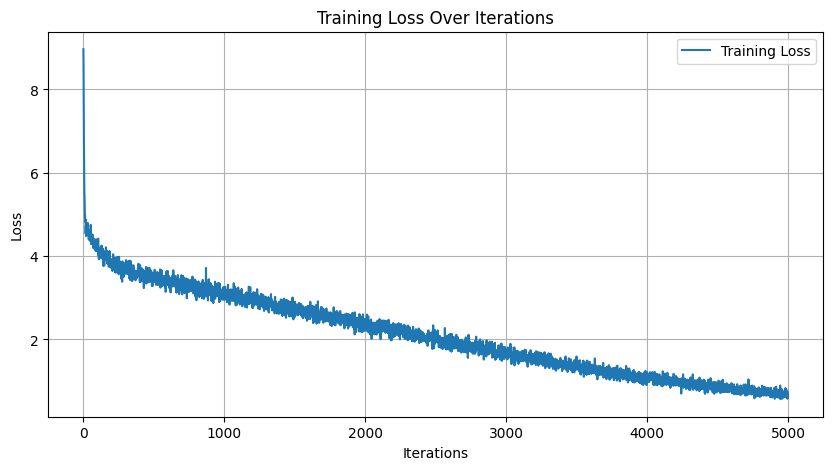

In [ ]:
# Configure training/optimization
clip = 50.0
teacher_forcing_ratio = 1.0
learning_rate = 0.0001
decoder_learning_ratio = 5.0
n_iteration = 5000
print_every = 1
save_every = 500

# Ensure dropout layers are in train mode
encoder.train()
decoder.train()

# Initialize optimizers
print('Building optimizers ...')
encoder_optimizer = optim.Adam(encoder.parameters(), lr=learning_rate)
decoder_optimizer = optim.Adam(decoder.parameters(), lr=learning_rate * decoder_learning_ratio)
if loadFilename:
    encoder_optimizer.load_state_dict(encoder_optimizer_sd)
    decoder_optimizer.load_state_dict(decoder_optimizer_sd)

# If you have CUDA, configure CUDA to call
for state in encoder_optimizer.state.values():
    for k, v in state.items():
        if isinstance(v, torch.Tensor):
            state[k] = v.cuda()

for state in decoder_optimizer.state.values():
    for k, v in state.items():
        if isinstance(v, torch.Tensor):
            state[k] = v.cuda()

# # Run training iterations
# print("Starting Training!")
# trainIters(model_name, voc, pairs, encoder, decoder, encoder_optimizer, decoder_optimizer,
#            embedding, encoder_n_layers, decoder_n_layers, save_dir, n_iteration, batch_size,
#            print_every, save_every, clip, corpus_name, loadFilename)
# Run training iterations
print("Starting Training!")
trainIters(model_name, voc, pairs, encoder, decoder, encoder_optimizer, decoder_optimizer, embedding,
           encoder_n_layers, decoder_n_layers, save_dir, n_iteration, batch_size, print_every,
           save_every, clip, corpus_name, loadFilename)

# Testing our Bot here

In [ ]:
# Set dropout layers to ``eval`` mode
encoder.eval()
decoder.eval()

# Initialize search module
searcher = GreedySearchDecoder(encoder, decoder)

# Begin chatting (uncomment and run the following line to begin)
evaluateInput(encoder, decoder, searcher, voc)

> Hi
Bot: hi . ? ? ? ?
> how are ypu
Error: Encountered unknown word.
> how are you?
Bot: fine . . . . .
> glad to hear that
Bot: good to see you again . ? ?
> yeah me too
Bot: do it ! now ? ? ?
> nothing
Bot: how long have we known each other now ?
> we have known each other for a day only
Bot: well i think that was a long time .
> yeah
Bot: what was your news baxter ? ? ?
> what is a baxter?
Bot: i don t know . ? ?
> okay, see ya
Bot: see what ? ? ? ?
> see you later
Bot: righto ! ! ! !


KeyboardInterrupt: Interrupted by user

In [ ]:
# If Model is good we will export it for futher use
encoder_save_path = "encoder_model_1.pth"
decoder_save_path = "decoder_model_1.pth"


torch.save(encoder.state_dict(), encoder_save_path)
torch.save(decoder.state_dict(), decoder_save_path)


print(f"Encoder model saved at {encoder_save_path}")
print(f"Decoder model saved at {decoder_save_path}")



Encoder model saved at encoder_model_1.pth
Decoder model saved at decoder_model_1.pth


# CNN Implementation

In [ ]:
import pandas as pd
import numpy as np
import re
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Load the movie lines dataset assuming tab-separated format
lines = pd.read_csv('formatted_movie_lines.txt', sep='\t', header=None, names=['line1', 'line2'])

# Check the structure of the DataFrame
print("Dataset sample:")
print(lines.head())

# Create a random sentiment label for illustration purposes (use actual labels if available)
lines['sentiment'] = np.random.choice([0, 1], size=len(lines))  # Random binary sentiment

# Preprocessing the text: Lowercasing, removing non-alphanumeric characters
lines['cleaned_line1'] = lines['line1'].apply(lambda x: re.sub(r"[^a-zA-Z0-9\s]", "", x.lower()))
lines['cleaned_line2'] = lines['line2'].apply(lambda x: re.sub(r"[^a-zA-Z0-9\s]", "", x.lower()))

# Combine both lines into one text column (optional step)
lines['combined_text'] = lines['cleaned_line1'] + " " + lines['cleaned_line2']

# Show the cleaned text
print("\nCleaned dataset sample:")
print(lines[['combined_text', 'sentiment']].head())

# Splitting data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(lines['combined_text'], lines['sentiment'], test_size=0.2, random_state=42)

# Tokenization
tokenizer = Tokenizer(num_words=10000)  # Use a vocabulary of 10,000 most frequent words
tokenizer.fit_on_texts(X_train)

# Convert text to sequences
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

# Padding the sequences to ensure uniform input size
X_train_padded = pad_sequences(X_train_seq, padding='post', maxlen=100)  # Max sequence length: 100
X_test_padded = pad_sequences(X_test_seq, padding='post', maxlen=100)



# Output the shapes of the training and test sets
print("\nPadded data shapes:")
print(f"X_train_padded shape: {X_train_padded.shape}")
print(f"X_test_padded shape: {X_test_padded.shape}")


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Dense, Embedding, Flatten, Dropout

# Define the CNN model
model = Sequential([
    Embedding(input_dim=10000, output_dim=128, input_length=100),  # Embedding layer for tokenized text
    Conv1D(128, 5, activation='relu'),  # Convolutional layer
    MaxPooling1D(pool_size=2),  # Max pooling
    Dropout(0.5),  # Dropout layer for regularization
    Flatten(),  # Flatten the output
    Dense(128, activation='relu'),  # Dense layer
    Dense(1, activation='sigmoid')  # Output layer (binary classification)
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train_padded, y_train, epochs=50, batch_size=64, validation_data=(X_test_padded, y_test))


In [ ]:
import matplotlib.pyplot as plt

# Function to plot the loss graph
def plot_loss_history(history):
    plt.figure(figsize=(8, 6))
    plt.plot(history.history['loss'], label='Training Loss')
    #plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

# Plot the loss graph after training
plot_loss_history(history)

# Gemini Implementation

This code cannot work directly, it has to run as a RESTFUL API

In [ ]:
from flask import Flask, jsonify, request
from flask_cors import CORS  # <-- Import CORS
import google.generativeai as genai
import os

app = Flask(__name__)
CORS(app)  # <-- Enable CORS for all routes

# Set up the API key from environment or config
genai.configure(api_key=' ')

@app.route("/chat", methods=["POST"])
def chat():
    prompt = request.json.get("message")
    model = genai.GenerativeModel("gemini-1.5-flash")
    chat = model.start_chat(history=[])
    response = chat.send_message(prompt, stream=False)
    return jsonify({"response": response.text})


if __name__ == "__main__":
    app.run(debug=True)
